In [1]:
import sys

In [2]:
sys.path.insert(0, '../')


In [16]:
""" This module implements the base function to implement a VQE for a Ising Chain with Transverse Field. """
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
from jax import jit
from functools import partial

from matplotlib import pyplot as plt

import copy
import tqdm  # Pretty progress bars

import warnings

warnings.filterwarnings(
    "ignore",
    message="For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires.Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.",
)


import vqe as vqe

##############

def circuit_wall_RY(N, param, index=0):
    """
    Apply independent RY rotations to each wire in a Pennylane circuit

    Parameters
    ----------
    N : int
        Number of qubits
    params: np.ndarray
        Array of parameters/rotation for the circuit
    index: int
        Index from where to pick the elements from the params array

    Returns
    -------
    int
        Updated starting index of params array for further rotations
    """
    # Apply RY to each wire:
    for spin in range(N):
        qml.RY(param[index + spin], wires=spin)

    return index + N

def circuit_anomaly_entanglement(N, wires, wires_trash):
    """
    Applies CX between a wire and a trash wire for each 
    wire/trashwire
    
    Parameters
    ----------
    N : int
        Number of qubits
    wires : np.ndarray
        Array of the indexes of non-trash qubits
    wires_trash : np.ndarray
        Array of the indexes of trash qubits (np.1dsetdiff(np.arange(N),wires))
    """
    # Connection between trash wires
    for wire, wire_next in zip(wires_trash[0::2], wires_trash[1::2]):
        qml.CNOT(wires = [int(wire), int(wire_next)])
    for wire, wire_next in zip(wires_trash[1::2], wires_trash[2::2]):
        qml.CNOT(wires = [int(wire), int(wire_next)])
        
    # Connections wires -> trash_wires
    for trash_idx, wire in enumerate(wires):
        trash_idx = 0 if trash_idx > len(wires_trash) else trash_idx
        qml.CNOT(wires = [int(wire), int(wires_trash[trash_idx])])


def anomaly_circuit(N, vqe_circuit, vqe_params, params):
    """
    Building function for the circuit:
          VQE(params_vqe) + Anomaly(params)
    
    Parameters
    ----------
    N : int
        Number of qubits
    vqe_circuit : function
        Function of the VQE Circuit
    vqe_params : np.ndarray
        Array of VQE parameters (states)
    params: np.ndarray
        Array of parameters/rotation for the circuit
        
    Returns
    -------
    np.ndarray
        Index of the trash qubits
    int
        Number of parameters of the circuit    
    """
    # Number of wires that will not be measured |phi>
    n_wires = N//2 + N%2
    # Number of wires that will be measured |0>^k
    n_trash = N//2
    
    wires = np.concatenate((np.arange(0, n_wires//2 + n_wires%2), np.arange(N-n_wires//2,N) ))
    wires_trash = np.setdiff1d(np.arange(N), wires)

    vqe_circuit(N, vqe_params)
    
    # Visual Separation VQE||Anomaly
    qml.Barrier()
    qml.Barrier()
    index = circuit_wall_RY(N, params)
    circuit_anomaly_entanglement(N, wires, wires_trash)
    qml.Barrier()
    index = circuit_wall_RY(N, params, index)
    circuit_anomaly_entanglement(N, wires, wires_trash)
    qml.Barrier()
    index = circuit_wall_RY(N, params, index)
    
    return index

class encoder:
    def __init__(self, vqe, encoder_circuit):
        '''
        Class for the Anomaly Detection algorithm
        
        Parameters
        ----------
        vqe : class
            VQE class
        qcnn_circuit : 
            Function of the QCNN circuit
        '''
        self.N          = vqe.N
        self.J          = vqe.J
        self.n_states   = vqe.n_states
        self.circuit    = lambda vqe_p, enc_p: encoder_circuit(self.N, vqe.circuit_fun, vqe_p, enc_p)
        self.n_params   = self.circuit([0] * 10000, [0] * 10000)
        self.params     = np.array([np.pi / 4] * self.n_params)
        self.device     = vqe.device
        
        self.vqe_states = np.array(vqe.vqe_states)
        self.lams       = np.linspace(0, 2 *self.J, self.n_states)
        self.labels     = np.array(vqe.labels)
        
        self.circuit_fun = encoder_circuit
        self.n_wires = self.N//2 + self.N%2
        self.n_trash = self.N//2
        self.wires = np.concatenate((np.arange(0, self.n_wires//2 + self.n_wires%2), np.arange(self.N-self.n_wires//2,self.N) ))
        self.wires_trash = np.setdiff1d(np.arange(self.N), self.wires)
    
    def show_circuit(self):
        '''
        Prints the current circuit defined by self.circuit
        '''
        @qml.qnode(self.device, interface="jax")
        def enc_state(self):
            self.circuit([0]*1000, np.arange(self.n_params) )

            return qml.state()
        
        drawer = qml.draw(enc_state)
        print(drawer(self))
        
    def train(self, lr, n_epochs, train_index, circuit = False, plot = False):
        """
        Training function for the Anomaly Detector.

        Parameters
        ----------
        lr : float
            Learning rate to be multiplied in the circuit-gradient output
        n_epochs : int
            Total number of epochs for each learning
        train_index : np.ndarray
            Index of training points
        circuit : bool
            if True -> Prints the circuit
            if False -> It does not display the circuit
        plot : bool
            if True -> Display the loss curve
        """
        if circuit:
            # Display the circuit
            print("+--- CIRCUIT ---+")
            self.show_circuit()
        
        X_train = jnp.array(self.vqe_states[train_index])

        @qml.qnode(self.device, interface="jax")
        def encoder_circuit(vqe_params, params):
            self.circuit(vqe_params, params)

            # return <psi|H|psi>
            return [qml.expval(qml.PauliZ(int(k))) for k in self.wires_trash]

        v_encoder_circuit = jax.vmap(lambda p, x: encoder_circuit(x, p), in_axes = (None, 0) )

        def compress(params, vqe_params):
            return jnp.sum(1 - v_encoder_circuit(params, vqe_params) )/(2*len(vqe_params))

        jd_compress     = jax.jit(jax.grad(lambda p: compress(p, X_train)) )
        j_compress      = jax.jit(lambda p: compress(p, X_train))
        get_compression = jax.jit(lambda p: jnp.sum(v_encoder_circuit(p, X_train),axis=1)/len(self.wires_trash) )

        params = copy.copy(self.params)

        loss = []
        progress = tqdm.tqdm(range(n_epochs), position=0, leave=True)
        for epoch in range(n_epochs):
            params -= lr*jd_compress(params)

            if (epoch+1) % 100 == 0:
                loss.append(j_compress(params))
                progress.set_description('Cost: {0}'.format(loss[-1]) )
            progress.update(1)
            
        self.params = params

        if plot:
            fig, ax = plt.subplots(2, 1, figsize=(16,5))

            ax[0].scatter(train_index,  temp_train)
            if len(X_test) > 0:
                ax[0].scatter(np.setdiff1d(np.arange(len(X_train)+len(X_test)), train_index), temp_test , label = 'Test')
            ax[0].axvline(x=len(data)//2, color='red', linestyle='--')    
            ax[0].legend()
            ax[0].grid(True)

            plt.title('Loss of the encoder')
            plt.plot(np.arange(len(loss))*100, loss)
    
    def show_compression(self, train_index):
        X_train = jnp.array(self.vqe_states[train_index])
        test_index = np.setdiff1d(np.arange(len(self.vqe_states)),train_index)
        X_test = jnp.array(self.vqe_states[test_index])
        
        @qml.qnode(self.device, interface="jax")
        def encoder_circuit(vqe_params, params):
            self.circuit(vqe_params, params)

            # return <psi|H|psi>
            return [qml.expval(qml.PauliZ(int(k))) for k in self.wires_trash]
        
        v_encoder_circuit = jax.vmap(lambda x: encoder_circuit(x, self.params) )
        
        exps_train = (1 - np.sum(v_encoder_circuit(X_train), axis=1)/4)/2
        exps_test  = (1 - np.sum(v_encoder_circuit(X_test) , axis=1)/4)/2
        
        plt.figure(figsize = (10,3) )
        plt.scatter(train_index,  exps_train)
        plt.scatter(np.setdiff1d(np.arange(len(X_train)+len(X_test)), train_index), exps_test , label = 'Test')
        plt.axvline(x=len(self.vqe_states)//2, color='red', linestyle='--')    
        plt.legend()
        plt.grid(True)
        
    def save(filename):
        """
        Saves Encoder parameters to file
        
        Parameters
        ----------
        filename : str
            File where to save the parameters
        """
        
        things_to_save = [self.params, self.circuit_fun]
        
        with open(filename, 'wb') as f:
            pickle.dump(things_to_save, f)
            
def load(filename_vqe, filename_enc):
    """
    Load QCNN from VQE file and QCNN file
    """
    
    loaded_vqe = vqe.load(filename_vqe)
    
    with open(filename_qcnn, 'rb') as f:
            params, enc_circuit_fun = pickle.load(f)
            
    loaded_enc = encoder(vqe, enc_circuit_fun)
    loaded_enc.params = params
    
    return loaded_enc
    

In [17]:
myenc = encoder(vqe.load_vqe('../data/vqe.pkl'), anomaly_circuit)

In [18]:
myenc.show_circuit()

0: ──RY(0.00)──RX(0.00)──||─╭C────────────────────||──RY(0.00)──RX(0.00)──||─╭C──────────────────
1: ──RY(0.00)──RX(0.00)──||─╰X─╭C─────────────────||──RY(0.00)──RX(0.00)──||─╰X─╭C───────────────
2: ──RY(0.00)──RX(0.00)──||────╰X─╭C──────────────||──RY(0.00)──RX(0.00)──||────╰X─╭C────────────
3: ──RY(0.00)──RX(0.00)──||───────╰X─╭C───────────||──RY(0.00)──RX(0.00)──||───────╰X─╭C─────────
4: ──RY(0.00)──RX(0.00)──||──────────╰X─╭C────────||──RY(0.00)──RX(0.00)──||──────────╰X─╭C──────
5: ──RY(0.00)──RX(0.00)──||─────────────╰X─╭C─────||──RY(0.00)──RX(0.00)──||─────────────╰X─╭C───
6: ──RY(0.00)──RX(0.00)──||────────────────╰X─╭C──||──RY(0.00)──RX(0.00)──||────────────────╰X─╭C
7: ──RY(0.00)──RX(0.00)──||───────────────────╰X──||──RY(0.00)──RX(0.00)──||───────────────────╰X

───||──RY(0.00)──||──||──RY(0.00)────╭C────────||──RY(8.00)─────╭C────────||──RY(16.00)─┤  State
───||──RY(0.00)──||──||──RY(1.00)────│──╭C─────||──RY(9.00)─────│──╭C─────||──RY(17.00)─┤  State
───||──RY(0.00)──||──

In [19]:
myenc.train(0.03, 1000, [0,1,2,3,4,5], circuit = True)

+--- CIRCUIT ---+
0: ──RY(0.00)──RX(0.00)──||─╭C────────────────────||──RY(0.00)──RX(0.00)──||─╭C──────────────────
1: ──RY(0.00)──RX(0.00)──||─╰X─╭C─────────────────||──RY(0.00)──RX(0.00)──||─╰X─╭C───────────────
2: ──RY(0.00)──RX(0.00)──||────╰X─╭C──────────────||──RY(0.00)──RX(0.00)──||────╰X─╭C────────────
3: ──RY(0.00)──RX(0.00)──||───────╰X─╭C───────────||──RY(0.00)──RX(0.00)──||───────╰X─╭C─────────
4: ──RY(0.00)──RX(0.00)──||──────────╰X─╭C────────||──RY(0.00)──RX(0.00)──||──────────╰X─╭C──────
5: ──RY(0.00)──RX(0.00)──||─────────────╰X─╭C─────||──RY(0.00)──RX(0.00)──||─────────────╰X─╭C───
6: ──RY(0.00)──RX(0.00)──||────────────────╰X─╭C──||──RY(0.00)──RX(0.00)──||────────────────╰X─╭C
7: ──RY(0.00)──RX(0.00)──||───────────────────╰X──||──RY(0.00)──RX(0.00)──||───────────────────╰X

───||──RY(0.00)──||──||──RY(0.00)────╭C────────||──RY(8.00)─────╭C────────||──RY(16.00)─┤  State
───||──RY(0.00)──||──||──RY(1.00)────│──╭C─────||──RY(9.00)─────│──╭C─────||──RY(17.00)─┤  State
───

Cost: 0.00202729320153594: 100%|███████████| 1000/1000 [00:07<00:00, 142.22it/s]


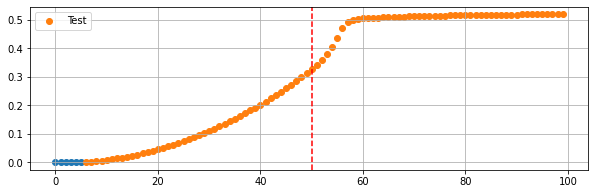

In [20]:
myenc.show_compression([0,1,2,3,4,5])